<a href="https://colab.research.google.com/github/Gdkmak/lrjSsoeUgm2pypnT/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pydot

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import export_graphviz
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve, auc

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
row_df = pd.read_csv('term-deposit-marketing-2020.csv')
row_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
row_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
row_df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [5]:
row_df.isnull().values.sum()

0

There is no null values in the dataset, which is a relieve. As you can see, there are some preprocessing work and feature engineering need to be done before applying ML algorithms. 
There some unreasnably values, such as -8019 in the balance and 4918 in the duraion, which is kinda an outliers that we should get rid of.


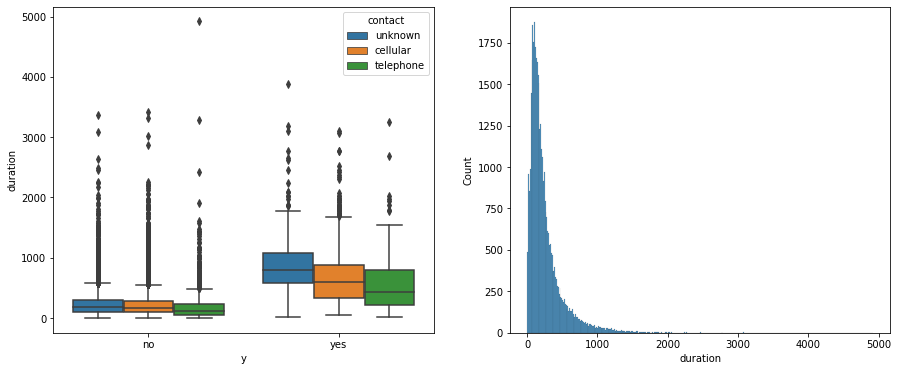

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x='y', y='duration', data=row_df, hue='contact', ax=ax1)
sns.histplot(row_df.duration, ax=ax2 )

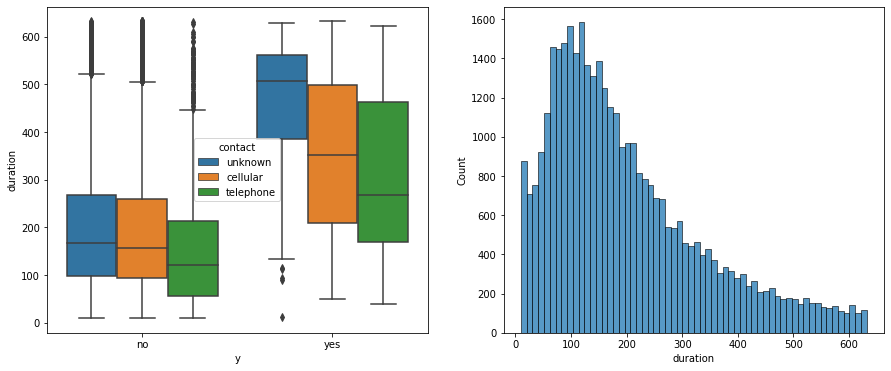

In [7]:
# dealing with outliers for duration variable 

Q1 = np.quantile(row_df['duration'], .25)
Q3 = np.quantile(row_df['duration'], .75)
IQR = Q3 -Q1
rm_outliers_df = row_df[row_df['duration'].between(10, (Q3 + 1.5*IQR), inclusive=True)]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(x='y', y='duration', data=rm_outliers_df, hue='contact', ax=ax1)
sns.histplot(rm_outliers_df.duration, ax=ax2 )


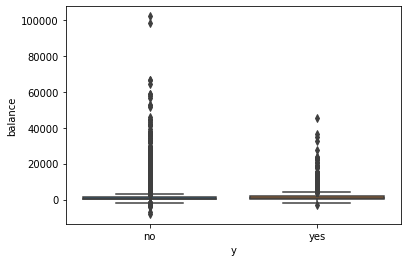

In [8]:
# outlier for the balance variable
sns.boxplot(x='y', y='balance', data=row_df)

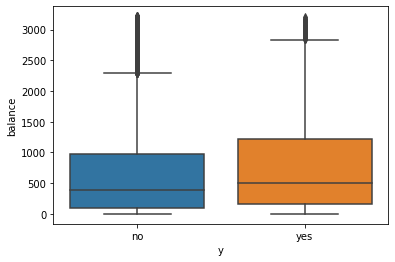

In [9]:
Q1 = np.quantile(row_df['balance'], .25)
Q3 = np.quantile(row_df['balance'], .75)
IQR = Q3 -Q1
rm_outliers_df = row_df[row_df['balance'].between(0, (Q3 + 1.5*IQR), inclusive=True)]

sns.boxplot(x='y', y='balance', data=rm_outliers_df)

In [10]:
# Campaign variable
rm_outliers_df.campaign.where(row_df.y == 'yes').value_counts()

1.0     994
2.0     594
3.0     272
4.0     169
5.0      83
6.0      55
7.0      24
8.0      21
9.0      12
10.0     10
11.0      9
13.0      6
17.0      5
15.0      4
12.0      3
14.0      3
16.0      2
24.0      1
32.0      1
20.0      1
29.0      1
Name: campaign, dtype: int64

I cannot see any significant information we can get from the campaign variable, most likely people bought from one or two calls. Hence it will be deleted later, the same thing applies for day variable.

I think we are set in terms of preprocessing the numerical variables. However, I have a gut feeling about the balance between yes and no in the dependent variable, I will check it now. 


[Text(0, 0, 'No'), Text(0, 0, 'Yes')]

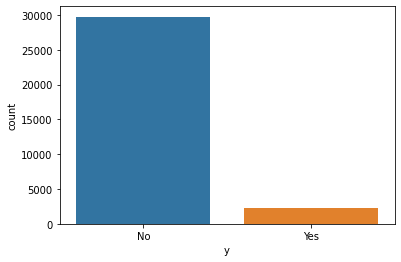

In [11]:
g = sns.countplot(x=rm_outliers_df.y) 
g.set_xticklabels(['No', 'Yes'])

Oops, as I expected the data is imbalanced. This is one of the major issues that data scientist fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy score can be misleading. In a dataset with highly unbalanced classes like this, the classifier will always “predicts” the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one.

Collecting more data helps here but there is no such option. Therefore to overcome this problem , I will try to resample the dataset a)oversampling and b)undersamling. a) The simplest implementation of oversampling is to duplicate random records from the minority class, which can cause overfishing. b) the  undersampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Of courser there are different techniques such as Tomek links and NearMiss but I will use a simplified version of sampling approche.

I will remove outliers then I will apply the undersampling approach. Look at the numeric variables

In [12]:
# Random undersampling using imblearn
# Imblearn is a libraries can help to implement such techniques
under_sampling = RandomUnderSampler(random_state=55, replacement=True)
x_under_sampling, y_under_sampling = under_sampling.fit_resample(rm_outliers_df, rm_outliers_df.y)

print('original dataset shape:', Counter(rm_outliers_df.y))
print('Resample dataset shape', Counter(y_under_sampling))

original dataset shape: Counter({'no': 29742, 'yes': 2270})
Resample dataset shape Counter({'no': 2270, 'yes': 2270})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# Recreate the new balanced dataframe
balanced_df = pd.DataFrame(x_under_sampling, columns=row_df.columns).sample(frac=1).reset_index(drop=True)
balanced_df[['age', 'balance', 'day', 'duration', 'campaign']] = balanced_df[['age', 'balance', 'day', 'duration', 'campaign']].apply(pd.to_numeric)
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540 entries, 0 to 4539
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4540 non-null   int64 
 1   job        4540 non-null   object
 2   marital    4540 non-null   object
 3   education  4540 non-null   object
 4   default    4540 non-null   object
 5   balance    4540 non-null   int64 
 6   housing    4540 non-null   object
 7   loan       4540 non-null   object
 8   contact    4540 non-null   object
 9   day        4540 non-null   int64 
 10  month      4540 non-null   object
 11  duration   4540 non-null   int64 
 12  campaign   4540 non-null   int64 
 13  y          4540 non-null   object
dtypes: int64(5), object(9)
memory usage: 496.7+ KB


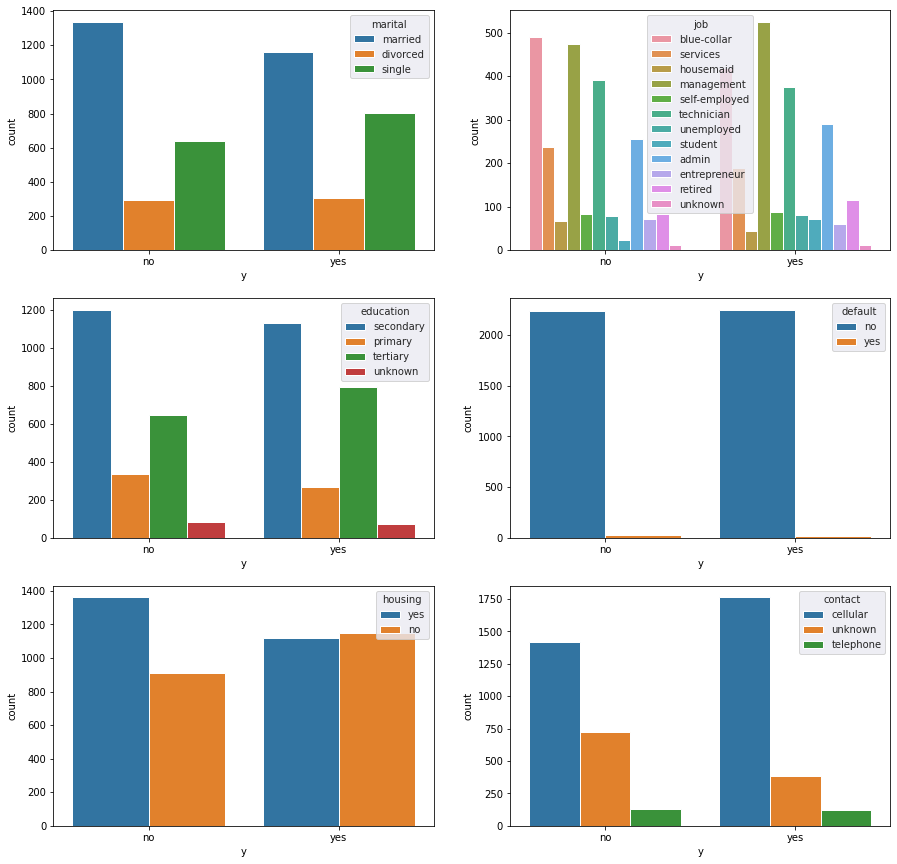

In [14]:
# Let's take a look at some categorical variables 
fig, ax = plt.subplots(3, 2, figsize=(15,15))
sns.set_style("dark")

sns.countplot(x='y', hue="marital", data=balanced_df, order=['no','yes'], ax=ax[0,0])
sns.countplot(x='y', hue="job", data=balanced_df, order=['no','yes'], ax=ax[0,1])
sns.countplot(x='y', hue="education", data=balanced_df, order=['no','yes'], ax=ax[1,0])
sns.countplot(x='y', hue="default", data=balanced_df, order=['no','yes'], ax=ax[1,1])
sns.countplot(x='y', hue="housing", data=balanced_df, order=['no','yes'], ax=ax[2,0])
sns.countplot(x='y', hue="contact", data=balanced_df, order=['no','yes'], ax=ax[2,1])

There are not a lot of differences in features like default and education, however, interestingly in feature like marital we can motice that more singls are buying the product over the phone, and people who were contacted by phone are more likely to buy as well. 

In [15]:
tmp_df = balanced_df.loc[:,['month','y']]
tmp_df['0_1'] =  tmp_df.y.map(dict(yes=1, no=0))
tmp_df.groupby(by=['month'])['0_1'].sum().sort_values(ascending=False)

month
may    614
apr    370
jul    313
aug    235
jun    230
feb    204
nov    144
mar     96
jan     33
oct     30
dec      1
Name: 0_1, dtype: int64

It looks like there is seasonality in the data. Especially in spring and summer there are more buyers for the prodcts, the months between (apr-aug). I will split the data here to 3 categories (septemper is missing). (feb-may)(jun-sep) and (oct-jan)

In [16]:
# Encode months to bucket them later in three seasons 'spring','summer', 'winter'
balanced_df['encoded_month'] = balanced_df.month.map(dict(jan=12, feb=1, mar=2 , apr=3, may=4, jun=5, jul=6, aug=7, sep=8, oct=9, nov=10, dec=11))
bins = [0,4,8,12]
names = ['spring','summer', 'winter']
balanced_df['season'] = pd.cut(balanced_df['encoded_month'], bins, labels=names)

In [17]:
# Delete unwanted variables from the dataframe
balanced_df.drop(['default','education', 'day', 'month', 'campaign', 'encoded_month'], axis=1, inplace=True)

In [18]:
# Create 5 folds for cross validation
balanced_df['kfold'] = -1

# Balanced_df = balanced_df.sample(frac = 1).reset_index(drop=True)
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(X= balanced_df, y= balanced_df.y.values)): 
  balanced_df.loc[val_idx, 'kfold']  = fold

In [19]:
# Create target variable y
balanced_df['y'] = balanced_df.y.map(dict(yes=1, no=0))

# One hot encoding for categorical variables
df = pd.get_dummies(balanced_df)

Average performance score in Accuracy metrics is 0.85 
The avg. of AUC score is 0.9165625181936387 


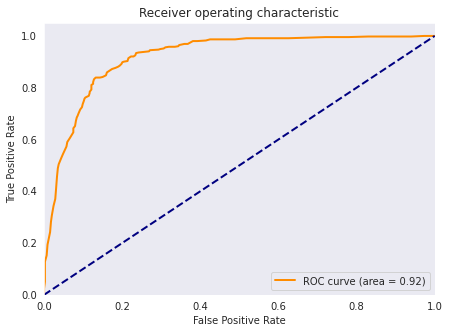

In [20]:
# Model training and inference

fold_mapping = {
  0: [1, 2, 3, 4],
  1: [0, 2, 3, 4],
  2: [0, 1, 3, 4],
  3: [0, 1, 2, 4],
  4: [0, 1, 2, 3],
}

avg_performance_score = 0.0
avg_roc_auc = 0.0 

for FOLD in range(5):
  train_df = df[df.kfold.isin(fold_mapping.get(FOLD))]
  valid_df = df[df.kfold == FOLD]
  
  y_train = train_df.y 
  x_train = train_df.drop(['y', 'kfold'], axis=1)

  y_test = valid_df.y 
  x_test = valid_df.drop(['y', 'kfold'], axis=1) 
  
  # Simple random forest classifier 
  random_forest = RandomForestClassifier(n_estimators=100,  bootstrap = True, max_features='sqrt')
  random_forest.fit(x_train, y_train)
  preds = random_forest.predict(x_test)
  preds_proba = random_forest.predict_proba(x_test)[:,1]

  # Use two metrics to evaluate the performance of each fold 
  acc = accuracy_score(y_test, preds)
  avg_performance_score += acc

  ruc = roc_auc_score(y_test, preds_proba)
  avg_roc_auc += ruc

avg_performance_score /= 5.0
avg_roc_auc /= 5.0

print(f'Average performance score in Accuracy metrics is {avg_performance_score:0.2f} \nThe avg. of AUC score is {avg_roc_auc} ')

# Plot the ROC curve 
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, preds_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(7,5))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Bonus(es):
a) A photo of a tree to show the client how the tree makes decision

b) Importance of the varibales 

In [21]:
# Feature list from the df
feature_list = list(df.drop(['y','kfold'], axis=1).columns)
tree_no = 3 

# Pull out one tree from the forest, export the image to a dot file to make graph 
tree = random_forest.estimators_[tree_no]
export_graphviz(tree, out_file='tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png(f'rf_tree_{tree_no}.png')

In [22]:
# Feature importances
importances = list(random_forest.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: duration             Importance: 0.52
Variable: balance              Importance: 0.12
Variable: age                  Importance: 0.1
Variable: season_spring        Importance: 0.03
Variable: housing_no           Importance: 0.02
Variable: housing_yes          Importance: 0.02
Variable: contact_cellular     Importance: 0.02
Variable: contact_unknown      Importance: 0.02
Variable: season_summer        Importance: 0.02
Variable: job_admin            Importance: 0.01
Variable: job_blue-collar      Importance: 0.01
Variable: job_management       Importance: 0.01
Variable: job_self-employed    Importance: 0.01
Variable: job_services         Importance: 0.01
Variable: job_technician       Importance: 0.01
Variable: job_unemployed       Importance: 0.01
Variable: marital_divorced     Importance: 0.01
Variable: marital_married      Importance: 0.01
Variable: marital_single       Importance: 0.01
Variable: loan_no              Importance: 0.01
Variable: loan_yes             Importance

At the top of the list is duration, the duration spent with customers looks important. This tells us the best predictor of success  is the duratoin, a rather intuitive finding. The second most important factor is the balance, also not that surprising. Then in the importance queue we have got age, contact and season. Occupation turns out to not be very helpful, along with the housing, marital status. These importances all make sense as we would not expect marital status to be a predictor of likelihood of a customer to buy or not. 

The model can be improved and those less important variables can be removed and hence the performance will not suffer. Additionally, if we are using a different model, say a support vector machine, we could use the random forest feature importances as a kind of feature selection method.